In [72]:
# import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt
import pickle



In [73]:
# Load the data
df =pd.read_csv('shoe_size_data.csv')
df.head()

,Hight,Weight,Shoe size,Gender
0,180,79.0,42,M
1,165,65.0,41,M
2,178,72.0,42,M
3,160,53.0,43,M
4,182,78.0,36,M


In [74]:
df['Shoe size'].value_counts()

Shoe size
42    23
41    21
40    21
39    15
38    12
44     9
43     7
36     1
Name: count, dtype: int64

In [75]:
# correct the spelling of the first column by renaming it
df = df.rename(columns={'Hight': 'Height'})
df.head()

,Height,Weight,Shoe size,Gender
0,180,79.0,42,M
1,165,65.0,41,M
2,178,72.0,42,M
3,160,53.0,43,M
4,182,78.0,36,M


In [76]:
#information about the data
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109 entries, 0 to 108
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Height     109 non-null    int64  
 1   Weight     109 non-null    float64
 2   Shoe size  109 non-null    int64  
 3   Gender     109 non-null    object 
dtypes: float64(1), int64(2), object(1)
memory usage: 3.5+ KB


In [77]:
df['Gender'].value_counts()

Gender
M    60
F    49
Name: count, dtype: int64

In [78]:
# Feature engineering: Add BMI
#df['BMI'] = df['Weight'] / (df['Height'] / 100) ** 2
#df.head()

In [79]:
# encoding the categorical column
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['Gender'] = le.fit_transform(df['Gender'])
df.head()

,Height,Weight,Shoe size,Gender
0,180,79.0,42,1
1,165,65.0,41,1
2,178,72.0,42,1
3,160,53.0,43,1
4,182,78.0,36,1


In [80]:
df.describe()

,Height,Weight,Shoe size,Gender
count,109.000000,109.000000,109.000000,109.000000
mean,173.403670,95.887156,40.743119,0.550459
std,13.581114,30.423234,1.771187,0.499745
min,140.000000,49.000000,36.000000,0.000000
25%,164.000000,68.000000,39.000000,0.000000
50%,174.000000,95.000000,41.000000,1.000000
75%,185.000000,118.000000,42.000000,1.000000
max,197.000000,159.000000,44.000000,1.000000


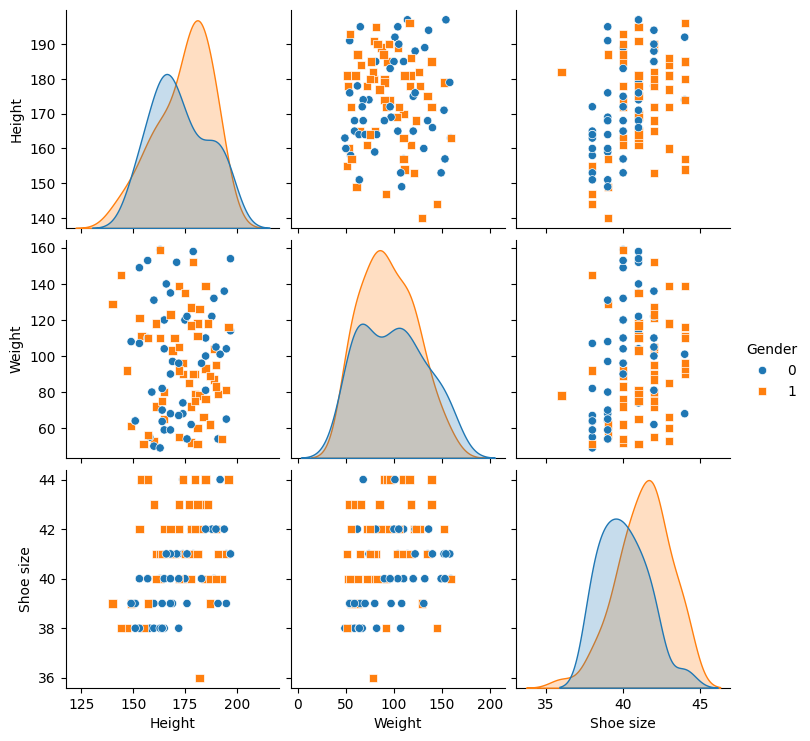

In [81]:
# Create a pairplot using seaborn
sns.pairplot(df, hue='Gender', markers=["o", "s"])

# Show the plot
plt.show()


In [82]:
from scipy.stats import chi2_contingency

# Create the DataFrame


# Create a contingency table
contingency_table = pd.crosstab(df['Shoe size'], df['Gender'])

# Perform Chi-Square Test
chi2, p, dof, ex = chi2_contingency(contingency_table)

# Output the results
print(f"Chi-Square Statistic: {chi2}")
print(f"P-Value: {p}")
print(f"Degrees of Freedom: {dof}")
print("Expected Frequencies:")
print(ex)

# Interpretation of the result
if p < 0.05:
    print("There is a significant correlation between Shoe size and Gender (reject the null hypothesis).")
else:
    print("There is no significant correlation between Shoe size and Gender (fail to reject the null hypothesis).")


Chi-Square Statistic: 20.137367865710814
P-Value: 0.005280490022832707
Degrees of Freedom: 7
Expected Frequencies:
[[ 0.44954128  0.55045872]
 [ 5.39449541  6.60550459]
 [ 6.74311927  8.25688073]
 [ 9.44036697 11.55963303]
 [ 9.44036697 11.55963303]
 [10.33944954 12.66055046]
 [ 3.14678899  3.85321101]
 [ 4.04587156  4.95412844]]
There is a significant correlation between Shoe size and Gender (reject the null hypothesis).


In [83]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score


# Separate features and target
X = df[['Height', 'Weight', 'Gender']]
y = df['Shoe size']

# Split the data with stratification on Gender
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=df['Gender'])

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both train and test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the SVR model
model = SVR()

# Train the model
model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = model.predict(X_test_scaled)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the results
print(f"Results for SVR:")
print(f"  Mean Squared Error: {mse:.4f}")
print(f"  R-squared: {r2:.4f}")


Results for SVR:
  Mean Squared Error: 2.4071
  R-squared: 0.2517


In [84]:
# Define the parameter grid for SVR
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['linear', 'rbf', 'poly']
}

# Initialize GridSearchCV
grid_search = GridSearchCV(SVR(), param_grid, cv=5, scoring='r2', verbose=2, n_jobs=-1)

# Perform grid search
grid_search.fit(X_train_scaled, y_train)

# Print the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best R2 Score:", grid_search.best_score_)

# Evaluate the best model
best_svr = grid_search.best_estimator_

# Define the evaluation metrics
scoring = {
    'MAE': make_scorer(mean_absolute_error),
    'MSE': make_scorer(mean_squared_error),
    'R2': make_scorer(r2_score)
}

# Perform cross-validation with the best model
for metric_name, scorer in scoring.items():
    cv_metric_results = cross_val_score(best_svr, X_train_scaled, y_train, cv=5, scoring=scorer)
    print(f"{metric_name} - Mean: {cv_metric_results.mean()}, Std: {cv_metric_results.std()}")



Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best Parameters: {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
Best R2 Score: 0.36066608287951685
MAE - Mean: 0.9822335396872421, Std: 0.36396002674528466
MSE - Mean: 1.9350712676661814, Std: 1.3057469075890735
R2 - Mean: 0.36066608287951685, Std: 0.2308535296326343


In [85]:
# Save the best model
filename = 'best_svr_model.pkl'
with open(filename, 'wb') as file:
    pickle.dump(best_svr, file)